### Wind droughts analysis: weekly analysis

In [1]:
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Input, MaxPooling2D, Flatten, MaxPool2D, MaxPool3D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Flatten, Reshape, Cropping2D, Embedding, BatchNormalization,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, Activation, Input, add, multiply
from tensorflow.keras.layers import ConvLSTM1D
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
from numpy import ones
import pandas as pd
#import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib
import yaml
import re
import pdb
import logging
from tqdm import tqdm


dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# plot with cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
#from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *
from utils.DNN_models import *
from utils.networks import *
from utils.datagenerators import *
from utils.utils_predictions import * 

2022-11-24 14:33:29.386577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/no21h426/.conda/envs/cartopy/share/proj failed


In [2]:
conf = yaml.safe_load(open("config.yaml"))
conf['PATH_ERA5']

'/storage/workspaces/giub_hydro/hydro/data/ERA5_extended/GridS2S/'

In [3]:
# if weekly or daily
qt = 0.1
weekly = False

In [4]:
# open data 
ws = xr.open_mfdataset('data/ws_1959-2021.nc')
ds = xr.open_mfdataset('data/ds_1959-2021.nc')
mjo = xr.open_mfdataset('data/mjo_1974-2021.nc')

In [5]:
mjo.copy()

<xarray.Dataset>
Dimensions:    (time: 17381)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2021-12-31
Data variables:
    RMM1       (time) float32 dask.array<chunksize=(17381,), meta=np.ndarray>
    RMM2       (time) float32 dask.array<chunksize=(17381,), meta=np.ndarray>
    amplitude  (time) float32 dask.array<chunksize=(17381,), meta=np.ndarray>
    phase      (time) float32 dask.array<chunksize=(17381,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Aug 23 11:42:05 2022: cdo settaxis,1974-06-01,00:00:00,...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [6]:
lats_y = ws.lat
lons_x = ws.lon

In [7]:
# adding dimensions to the temporal index MJO
mjo_dim = mjo.expand_dims({'lat': lats_y,'lon':lons_x})
mjo_dim = mjo_dim.transpose('time','lat','lon')

In [8]:
#ws = ws.ws
ws['time'] = pd.DatetimeIndex(ws.time.dt.date)

In [9]:
# adding more indices
df_aao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.aao.cdas.z700.19790101_current.csv')
df_ao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.ao.cdas.z1000.19500101_current.csv')
df_nao = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.nao.cdas.z500.19500101_current.csv')
df_pna = pd.read_csv('/storage/workspaces/giub_hydro/hydro/data/NOAA_index/norm.daily.pna.cdas.z500.19500101_current.csv')
aao = prepare_telec_indices(df_aao, 'aao_index_cdas', 'AAO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
ao = prepare_telec_indices(df_ao, 'ao_index_cdas', 'AO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
nao = prepare_telec_indices(df_nao, 'nao_index_cdas', 'NAO', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])
pna = prepare_telec_indices(df_pna, 'pna_index_cdas', 'PNA', lats_y, lons_x, conf['DATE_START'], conf['DATE_END'])

In [10]:
ws.load()

<xarray.Dataset>
Dimensions:  (time: 23011, lon: 41, lat: 34)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2021-12-31
  * lon      (lon) float64 -30.0 -28.5 -27.0 -25.5 -24.0 ... 25.5 27.0 28.5 30.0
  * lat      (lat) float64 79.5 78.0 76.5 75.0 73.5 ... 36.0 34.5 33.0 31.5 30.0
Data variables:
    ws       (time, lat, lon) float32 6.77 6.328 5.555 ... 2.717 4.058 4.882

In [11]:
# target variable
ws_weekly = ws.ws.resample(time="1W").mean(dim="time")

In [12]:
def weekly_standard_anomalies(ds, groupby = 'week'):
    """
    Output standardized weekly anomalies, climatology, and std.
    """

    climatology_mean = ds.groupby('time' + '.' + groupby).mean('time')
    climatology_std = ds.groupby('time' + '.' + groupby).std('time')

    stand_anomalies = xr.apply_ufunc(
                                lambda x, m, s: (x - m) / s,
                                ds.groupby('time' + '.' + groupby),
                                climatology_mean,
                                climatology_std,
                            )
    anomalies = xr.apply_ufunc(
                                lambda x, m: (x - m),
                                ds.groupby('time' + '.' + groupby),
                                climatology_mean,
                            )
    return stand_anomalies, anomalies

### Defining extremes

In [13]:
# 1. Define extremes based on percentile
# wind_weekly < 1th 

if not weekly:
    qq = xr.DataArray(ws.ws).quantile(qt, dim='time') 
    low_ws = xr.DataArray(ws.ws < qq)
    low_ws= low_ws*1
    
else:
    
    qq = xr.DataArray(ws_weekly).quantile(qt, dim='time') 
    low_ws = xr.DataArray(ws_weekly < qq)
    low_ws= low_ws*1

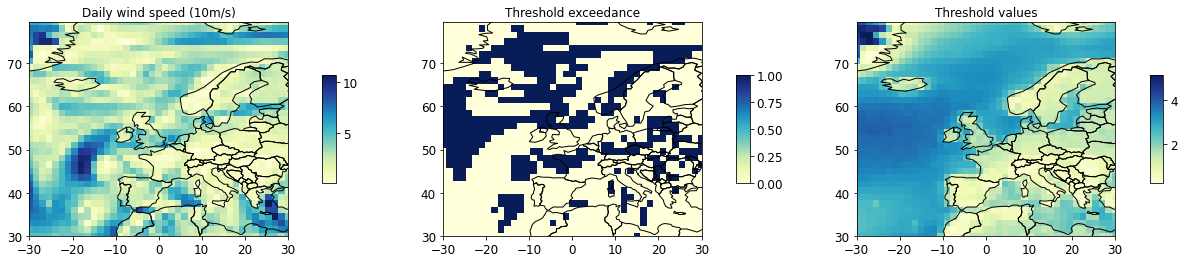

In [14]:
# Get the date with the max number of grid points with ws < threshold
x = low_ws.sum(dim=['lat', 'lon'])
plot_date = x.argmax(dim='time')
# Plot precip, threshold exceedance and threshold values
fig, axs = plt.subplots(1, 3, figsize=(21,4))

plot_map(axs[0], lons_x, lats_y, ws.ws[plot_date,:,:].to_numpy().squeeze(), title="Daily wind speed (10m/s)", cmap=mpl.cm.YlGnBu)
plot_map(axs[1], lons_x, lats_y, low_ws[plot_date,:,:].to_numpy().squeeze(), title="Threshold exceedance", cmap=mpl.cm.YlGnBu)
plot_map(axs[2], lons_x, lats_y, qq.to_numpy().squeeze(), title="Threshold values", cmap=mpl.cm.YlGnBu)

In [15]:
fig.savefig('figures/wind_thres.png', bbox_inches=0, transparent='true')

In [15]:
low_ws[:,0,0].sum()

<xarray.DataArray 'ws' ()>
array(2301)
Coordinates:
    lon       float64 -30.0
    lat       float64 79.5
    quantile  float64 0.1

### Definition based on standarized anomalies (not used for now)

In [16]:
ws_anom_sd, ws_anom = weekly_standard_anomalies(ws_weekly)

/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/storage/homefs/no21h426/.conda/envs/cartopy/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


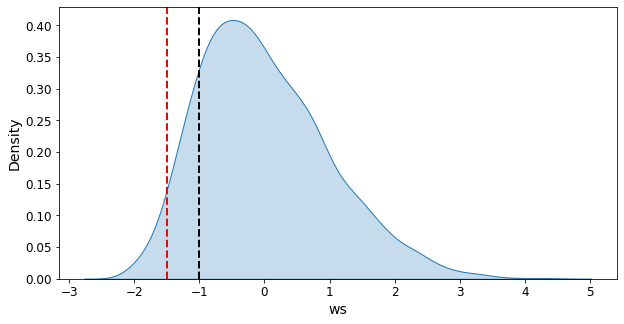

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.kdeplot(ws_anom_sd[:,10,10], shade=True)
# plotting mean line
plt.axvline(-1.5, color='red', linestyle='dashed', linewidth=2)
plt.axvline(-1, color='k', linestyle='dashed', linewidth=2)

In [18]:
# Define wind droughts based on standarised anomalies, let's start wih -1 to have more data
st_ex = -1
ws_ext = xr.where(ws_anom_sd < st_ex, 1, 0)

In [19]:
ws_ext[:,0,0].sum()

<xarray.DataArray 'ws' ()>
array(530)
Coordinates:
    lon      float64 -30.0
    lat      float64 79.5

In [20]:
# test all data
# Aggregate weekly
ds_tot = xr.merge([ds, mjo_dim, aao, ao, nao, pna],compat='no_conflicts')
dstot_weekly = ds_tot.resample(time='1W').mean()

dic_all = {
     'z':  [1000, 850, 500, 300, 200],                #let's use more geopotential levels
     'msl': None,
     't2m': None,
     'u':  [1000, 850, 500, 300, 200],  
     'v':  [1000, 850, 500, 300, 200],  
    # 'RMM1': None, 
    # 'RMM2': None,
    # 'amplitude': None,
    # 'phase': None,
    # 'AAO': None,
    # 'AO':None,
    # 'NAO': None,
    # 'PNA': None
    }


In [21]:
if not weekly: 
    dstot_train = ds_tot.sel(time=slice('{}-01-01'.format(conf['YY_TRAIN'][0]),
                                 '{}-12-31'.format(conf['YY_TRAIN'][1])))

    dstot_train['time'] = pd.DatetimeIndex(dstot_train.time.dt.date)
    dstot_test = ds_tot.sel(time=slice('{}-01-01'.format(conf['YY_TEST'][0]),
                                '{}-12-31'.format(conf['YY_TEST'][1])))

    dstot_test['time'] = pd.DatetimeIndex(dstot_test.time.dt.date)
    dy_train = ws.ws.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_TRAIN'][1]}"))
    dy_test = ws.ws.sel(time=slice(f"{conf['YY_TEST'][0]}", f"{conf['YY_TEST'][1]}"))
    # Next, TAKE EXTREMES!
    # First based on percentile
    dyex_train = low_ws.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_TRAIN'][1]}"))
    dyex_test = low_ws.sel(time=slice(f"{conf['YY_TEST'][0]}", f"{conf['YY_TEST'][1]}"))

else:
    # Split into training and test, then I will use DataGenerator class to get the validation
    dstot_train = dstot_weekly.sel(time=slice('{}-01-01'.format(conf['YY_TRAIN'][0]),
                                 '{}-12-31'.format(conf['YY_TRAIN'][1])))

    dstot_train['time'] = pd.DatetimeIndex(dstot_train.time.dt.date)
    dstot_test = dstot_weekly.sel(time=slice('{}-01-01'.format(conf['YY_TEST'][0]),
                                '{}-12-31'.format(conf['YY_TEST'][1])))

    dstot_test['time'] = pd.DatetimeIndex(dstot_test.time.dt.date)


    dy_train = ws_weekly.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_TRAIN'][1]}"))
    dy_test = ws_weekly.sel(time=slice(f"{conf['YY_TEST'][0]}", f"{conf['YY_TEST'][1]}"))
    # Next, TAKE EXTREMES!
    # First based on percentile
    dyex_train = low_ws.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_TRAIN'][1]}"))
    dyex_test = low_ws.sel(time=slice(f"{conf['YY_TEST'][0]}", f"{conf['YY_TEST'][1]}"))
    # based on anomalies
    #dyex2_train = ws_ext.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_TRAIN'][1]}"))
    #dyex2_test = ws_ext.sel(time=slice(f"{conf['YY_TEST'][0]}", f"{conf['YY_TEST'][1]}"))


In [22]:
# Svae the data
dstot_train.to_netcdf('data/model2_xtrm/dstot_train_day.nc')
dyex_train.to_netcdf('data/model2_xtrm/dyex_train_day.nc')
dstot_test.to_netcdf('data/model2_xtrm/dstot_test_day.nc')
dyex_test.to_netcdf('data/model2_xtrm/dyex_test_day.nc')

In [23]:
# training anomalies don't work well

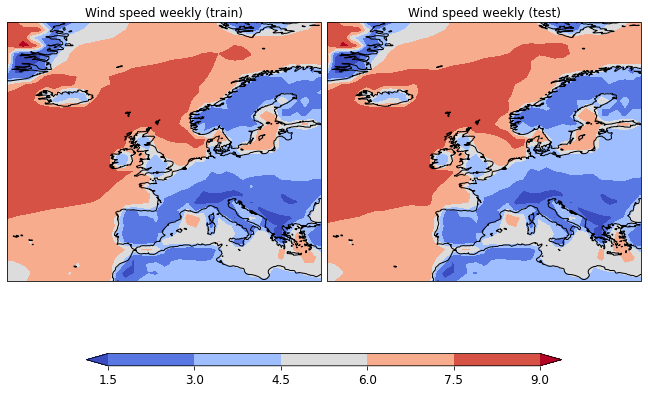

In [24]:
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

# Contour plot
cs=axs[0].contourf(lons_x, lats_y, dy_train.mean(dim='time'),
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')

 # Draw the coastines for each subplot
axs[0].coastlines()
axs[0].set_title('Wind speed weekly (train)')

cs=axs[1].contourf(lons_x, lats_y, dy_test.mean(dim='time'),
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')
axs[1].coastlines()
axs[1].set_title('Wind speed weekly (test)')
               
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

#### Datagenerator 
Direct forecast: here we train the model separately for each lead time 

In [25]:
BATCH_SIZE=32
max_leadtime = 1
lead_times = np.arange(1, max_leadtime + 1)
print(lead_times)

[1]


In [26]:
# model hyperparameters
output_scaling = 1
output_crop = None
EPOCHS = 50
#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

# Default training options
opt_training = {'epochs': EPOCHS,
                'callbacks': [callback]}

In [27]:
# compute weights
# Compute weights for the weighted binary crossentropy
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(low_ws.values),
    y=low_ws.values.flatten()
)

print('Weights for the weighted binary crossentropy:')
print(f'Classes: {np.unique(low_ws.values)}, weights: {weights}')

# Create loss function for the extremes
xtrm_loss = weighted_binary_cross_entropy(
    weights={0: weights[0].astype('float32'), 1: weights[1].astype('float32')})

Weights for the weighted binary crossentropy:
Classes: [0 1], weights: [0.55555287 5.0002173 ]


In [28]:
loss = xtrm_loss
metric = 'accuracy'

### Using the same day for predicting

In [29]:
# Note: at first, we dicuss to not use lead time (i.e. lead time 0), but if I don't use lead time 1 (as for model1) I will have inconsistencies when predicting (I think)

In [30]:
dg_train = DataGenerator(dstot_train.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_VALID']}")), 
                                             dyex_train.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_VALID']}")),
                                             dic_all, lead_time=max_leadtime, batch_size=BATCH_SIZE, load=True)

dg_valid = DataGenerator(dstot_train.sel(time=slice(f"{conf['YY_VALID']+1}", f"{conf['YY_TRAIN'][1]}")), 
                                             dyex_train.sel(time=slice(f"{conf['YY_VALID']+1}", f"{conf['YY_TRAIN'][1]}")),
                                             dic_all, lead_time=max_leadtime,  batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, load=True)

dg_test = DataGenerator(dstot_test, dyex_test, dic_all, lead_time=max_leadtime,
                                            batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False, load=True)

Loading data into RAM
Loading data into RAM
Loading data into RAM


In [32]:
models = {
          'Unet': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'dropout_rate':0.2, 'unet_use_upsample': False, 'bottleneck': False,  'for_extremes' : True},
                    'opt_optimizer': {'lr_method': 'Constant','lr':.00001}},
          'UnetConv': {'model': 'UnetConv', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'unet_use_upsample': False, 'bottleneck': False,  'for_extremes' : True},
                   'opt_optimizer': {'lr_method': 'Constant', 'lr':.00001}},
          'resnet': {'model': 'resnet', 'run': True,
                    'opt_model': {'out_channels': 1,'for_extremes' : True},
                    'opt_optimizer': {'lr_method': 'Constant','lr':.0000001}}}

### Train the models

train the model Unet for each lead time: direct forecast
{'lr_method': 'Constant', 'lr': 1e-05}
(34, 41)
(34, 41, 17)


2022-11-23 10:59:58.294115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 10:59:58.872012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


1
original design


2022-11-23 10:59:59.940473: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


Epoch 1/50
491/491 [==============================] - 31s 57ms/step - loss: 0.7585 - accuracy: 0.5422 - val_loss: 0.6662 - val_accuracy: 0.4925
Epoch 2/50
491/491 [==============================] - 26s 53ms/step - loss: 0.6867 - accuracy: 0.5679 - val_loss: 0.6489 - val_accuracy: 0.5044
Epoch 3/50
491/491 [==============================] - 26s 54ms/step - loss: 0.6649 - accuracy: 0.5799 - val_loss: 0.6374 - val_accuracy: 0.5180
Epoch 4/50
491/491 [==============================] - 26s 53ms/step - loss: 0.6513 - accuracy: 0.5882 - val_loss: 0.6293 - val_accuracy: 0.5186
Epoch 5/50
491/491 [==============================] - 26s 53ms/step - loss: 0.6411 - accuracy: 0.5955 - val_loss: 0.6197 - val_accuracy: 0.5407
Epoch 6/50
491/491 [==============================] - 26s 53ms/step - loss: 0.6323 - accuracy: 0.6020 - val_loss: 0.6106 - val_accuracy: 0.5640
Epoch 7/50
491/491 [==============================] - 27s 54ms/step - loss: 0.6245 - accuracy: 0.6108 - val_loss: 0.6032 - val_accuracy:

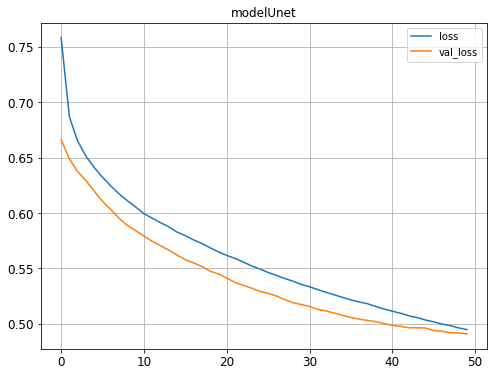

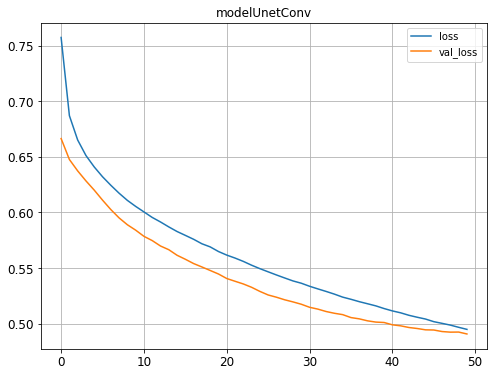

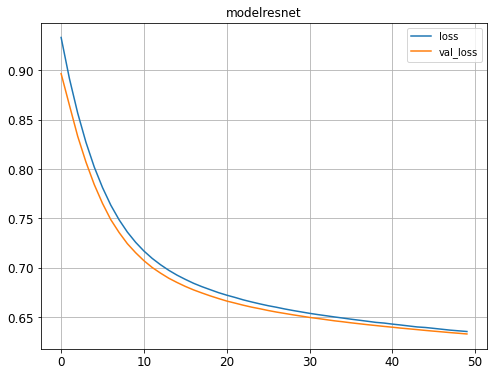

In [33]:
plot_his = True
m_lt = []
hist_lt = []
for m_id in models:

    # Clear session and set tf seed
    keras.backend.clear_session()
    tf.random.set_seed(42)

    if not models[m_id]['run']:
        continue
        
    # Extract model name and options
    model = models[m_id]['model']
    opt_model_i = models[m_id]['opt_model']
    opt_optimizer_i = models[m_id]['opt_optimizer']
    opt_model_new = opt_model_i.copy()
    opt_model_new.update(opt_model_i)
    opt_optimizer_new = opt_optimizer_i.copy()
    opt_optimizer_new.update(opt_optimizer_i)
    optimizer =  initiate_optimizer(dg_train, BATCH_SIZE, **opt_optimizer_new)
    print('train the model', model, 'for each lead time: direct forecast')
    print(opt_optimizer_new)
   # define inputs and outpust
    i_shape = dg_train.data.shape[1:]
    o_shape = dg_train.dy.shape[1:]
    print(o_shape)
    print(i_shape)
        
      
    if model == 'resnet':
            
        mod = build_res_unet(i_shape, **opt_model_new)
        
    else:
        
        mod = Unet_Inputs('Unet', i_shape, o_shape, input_index=None, **opt_model_new)


    mod.compile(loss=loss, optimizer=optimizer,  metrics=metric)
    his_mod = mod.fit(dg_train, validation_data=dg_valid, **opt_training)

    if plot_his:
        pd.DataFrame(his_mod.history)[['loss','val_loss']].plot(figsize=(8,6), grid=True)
        plt.title('model' + model )

         # save models
    nam_mod = f'ws_xtrm_{model}.h5'
    if model == 'resnet':
        mod.save_weights(f'tmp/{nam_mod}')
    else:
        mod.model.save_weights(f'tmp/{nam_mod}')
   
    m_lt.append(mod)
    hist_lt.append(his_mod)

In [45]:
### Part 2: Training the models for different lead times--testing direct forecasts approach

1
Loading data into RAM
Loading data into RAM
Loading data into RAM
train the model Unet for each lead time: direct forecast
{'lr_method': 'Constant', 'lr': 1e-05}
(34, 41)
(34, 41, 18)
1
original design
Epoch 1/50
58/58 [==============================] - 8s 98ms/step - loss: 0.9184 - accuracy: 0.5403 - val_loss: 0.7095 - val_accuracy: 0.6438
Epoch 2/50
58/58 [==============================] - 4s 71ms/step - loss: 0.8279 - accuracy: 0.5335 - val_loss: 0.6846 - val_accuracy: 0.5323
Epoch 3/50
58/58 [==============================] - 4s 71ms/step - loss: 0.7888 - accuracy: 0.5443 - val_loss: 0.6779 - val_accuracy: 0.5081
Epoch 4/50
58/58 [==============================] - 4s 71ms/step - loss: 0.7681 - accuracy: 0.5427 - val_loss: 0.6744 - val_accuracy: 0.5081
Epoch 5/50
58/58 [==============================] - 4s 71ms/step - loss: 0.7466 - accuracy: 0.5468 - val_loss: 0.6718 - val_accuracy: 0.5129
Epoch 6/50
58/58 [==============================] - 4s 71ms/step - loss: 0.7338 - accuracy:

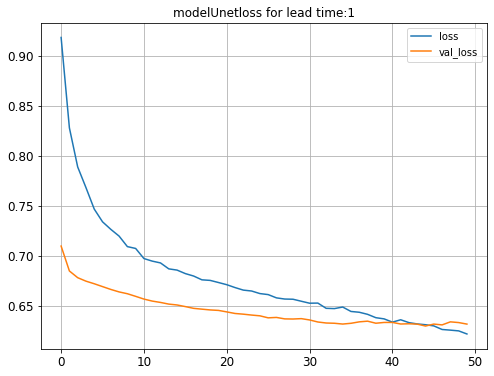

In [37]:
dg_train = []
dg_test = []
dg_valid = []
plot_his = True

m_lt = []
hist_lt = []


for lead_time in lead_times:
    print(lead_time)
    lt_train = DataGenerator(dstot_train.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_VALID']}")), 
                                             dyex_train.sel(time=slice(f"{conf['YY_TRAIN'][0]}", f"{conf['YY_VALID']}")),
                                             dic_all, lead_time=lead_time, batch_size=BATCH_SIZE, load=True)

    lt_valid = DataGenerator(dstot_train.sel(time=slice(f"{conf['YY_VALID']+1}", f"{conf['YY_TRAIN'][1]}")), 
                                             dyex_train.sel(time=slice(f"{conf['YY_VALID']+1}", f"{conf['YY_TRAIN'][1]}")),
                                             dic_all, lead_time=lead_time,  batch_size=BATCH_SIZE, mean=lt_train.mean, std=lt_train.std, load=True)
        #test
    lt_test = DataGenerator(dstot_test, dyex_test, dic_all, lead_time=lead_time,
                                            batch_size=BATCH_SIZE, mean=lt_train.mean, std=lt_train.std, shuffle=False, load=True)
    dg_train.append(lt_train)
    dg_valid.append(lt_valid)
    dg_test.append(lt_test)
    
    
    for m_id in models:


         # Clear session and set tf seed
        keras.backend.clear_session()
        tf.random.set_seed(42)

        if not models[m_id]['run']:
            continue
        # Extract model name and options
        model = models[m_id]['model']
        opt_model_i = models[m_id]['opt_model']
        opt_optimizer_i = models[m_id]['opt_optimizer']
        opt_model_new = opt_model_i.copy()
        opt_model_new.update(opt_model_i)
        opt_optimizer_new = opt_optimizer_i.copy()
        opt_optimizer_new.update(opt_optimizer_i)
        optimizer =  initiate_optimizer(lt_train, BATCH_SIZE, **opt_optimizer_new)
        print('train the model', model, 'for each lead time: direct forecast')
        print(opt_optimizer_new)
       # define inputs and outpust
        i_shape = lt_train.data.shape[1:]
        o_shape = lt_train.dy.shape[1:]
        print(o_shape)
        print(i_shape)
        

            
        if model == 'resnet':
            
            mod = build_res_unet(i_shape, **opt_model_new)
        else:
            mod = Unet_Inputs('Unet', i_shape, o_shape, input_index=None, **opt_model_new)


        mod.compile(loss=loss, optimizer=optimizer,  metrics=metric)
        his_mod = mod.fit(lt_train, validation_data=lt_valid, **opt_training)

        if plot_his:
            pd.DataFrame(his_mod.history)[['loss','val_loss']].plot(figsize=(8,6), grid=True)
            plt.title('model' + model + 'loss for lead time:' + str(lead_time))

         # save models
        nam_mod = f'ws_xtrm_{model}_lead_time_{lead_time}.h5'
        if model == 'resnet':
            mod.save_weights(f'tmp/{nam_mod}')
        else:
            mod.model.save_weights(f'tmp/{nam_mod}')
   
        m_lt.append(mod)
        hist_lt.append(his_mod)

### Predict

In [ ]:
pred_mod = []
precision_lead_time = []
recall_lead_time = []
auc_lead_time = []

precision_map = []
recall_map = []
auc_map = []

plot = True

for lead_time in lead_times:

    print(lead_time)

    lt_test = dg_test[lead_time-1]    
    nam_mod = f'ws_xtrm_{model}_lead_time_{lead_time}.h5'
    tmp_file = pathlib.Path (f'tmp/{nam_mod}')
    print(tmp_file)

    if tmp_file.exists :

        print('train the model', model, 'for each lead time: direct forecast')
               # define inputs and outpust
        i_shape = lt_test.data.shape[1:]
        o_shape = lt_test.dy.shape[1:]
        print(o_shape)
        print(i_shape)


        if model == 'resnet':
            mod = build_res_unet(i_shape)
        else:
            mod = Unet_Inputs('Unet', i_shape, o_shape, input_index=None)

        print( 'create predictions')
        pred_lt = create_predictions(mod, lt_test)
        # assess scores
        y_pred_bool = pred_lt > 0.5
        y_pred_bool = y_pred_bool * 1
        y_xtrm = dg_test[lead_time-1].dy.to_numpy().squeeze()
        # score matrix
        precision, recall = eval_confusion_matrix_scores_on_map(y_xtrm[:lt_test.n_samples], y_pred_bool)
        roc_auc = eval_roc_auc_score_on_map(y_xtrm[:lt_test.n_samples], pred_lt)
        
        precision_map.append(precision)
        recall_map.append(recall)
        auc_map.append(roc_auc)
        
       
        
        # weighted averages metrics
        precision_wg = compute_weighted_score(precision, lats_y, lons_x)
        recall_wg = compute_weighted_score(recall, lats_y, lons_x)
        auc_wg = compute_weighted_score(roc_auc, lats_y, lons_x)


        pred_mod.append(pred_lt)
        precision_lead_time.append(precision_wg)
        recall_lead_time.append(recall_wg)
        auc_lead_time.append(auc_wg)
        


In [ ]:
if plot:
    
    print("plot precision")
    map_metric(precision_map,  lats_y, lons_x, lead_times, 'precision')
    
    print("plot recall")
    map_metric(recall_map,  lats_y, lons_x, lead_times, 'recall')
    
    print("plot auc")
    map_metric(recall_map,  lats_y, lons_x, lead_times, 'auc')